# Residual Force Compensation

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nptdms import TdmsFile

In [9]:
# 1) TDMS 파일 로드 & Raw Force 시각화
file_path = '../data/25-05-14_2.tdms'

tdms = TdmsFile.read(file_path)

print("✅ Available groups and channels:")
group_channel_map = {}
for grp in tdms.groups():
    name = grp.name
    channels = [ch.name for ch in grp.channels()]
    group_channel_map[name] = channels
    print(f" - Group: {name}")
    for ch in channels:
        print(f"    • {ch}")

✅ Available groups and channels:
 - Group: Datas
    • Time (ms)
    • Reference Position X
    • Reference Position Y
    • Measured Position X
    • Measured Position Y
    • Reference Tension L
    • Reference Tension R
    • Reference Tension T
    • Measured Tension L
    • Measured Tension R
    • Measured Tension T
    • RBF1
    • RBF2
    • RBF3
    • Trajectory
    • Performance
    • Force X
    • Force y
    • Damp1
    • Damp2
    • Damp3


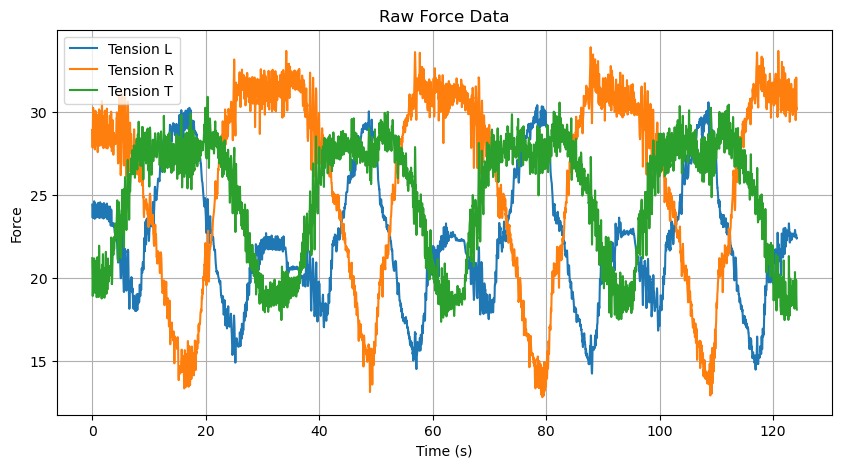

In [10]:
tdms = TdmsFile.read(file_path)
group = 'Datas' if 'Datas' in [g.name for g in tdms.groups()] else tdms.groups()[0].name

# 채널값 추출 (스케일 적용)
ten_l = tdms[group]['Measured Tension L'][:]
ten_r = tdms[group]['Measured Tension R'][:]
ten_t = tdms[group]['Measured Tension T'][:]
time = np.arange(len(ten_l)) / 50  # sample_rate=50

plt.figure(figsize=(10,5))
plt.plot(time, ten_l, color='C0', label='Tension L')      # 파란색
plt.plot(time, ten_r, color='C1', label='Tension R')      # 주황색
plt.plot(time, ten_t, color='C2', label='Tension T')      # 초록색
plt.title('Raw Force Data')
plt.xlabel('Time (s)'); plt.ylabel('Force')
plt.legend(); plt.grid(True)
plt.show()


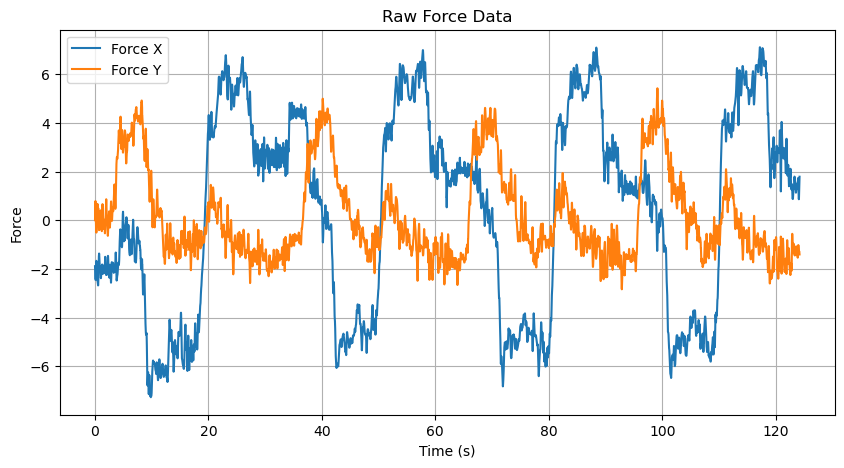

In [11]:

# 채널값 추출 (스케일 적용)
fx = tdms[group]['Force X'][:]
fy = tdms[group]['Force y'][:]
time = np.arange(len(fx)) / 50  # sample_rate=50

plt.figure(figsize=(10,5))
plt.plot(time, fx, color='C0', label='Force X')      # 파란색
plt.plot(time, fy, color='C1', label='Force Y')      # 주황색
plt.title('Raw Force Data')
plt.xlabel('Time (s)'); plt.ylabel('Force')
plt.legend(); plt.grid(True)
plt.show()


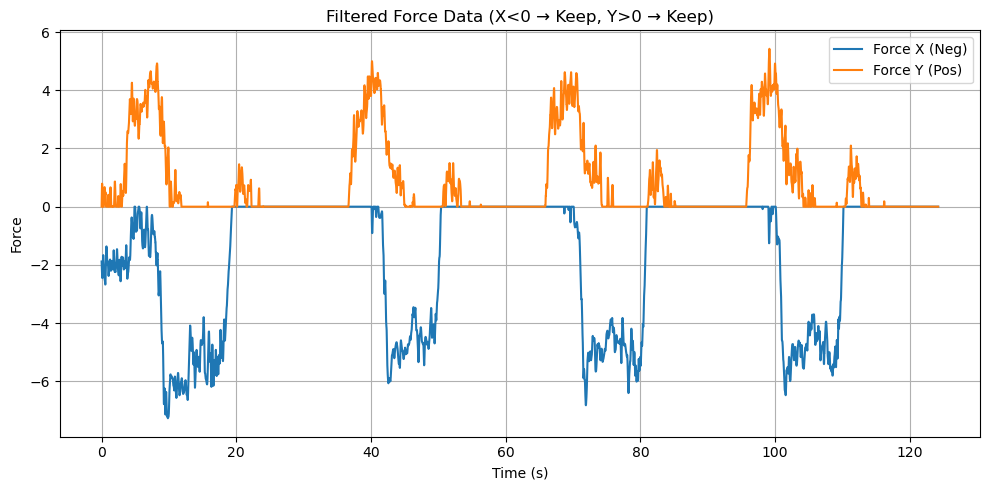

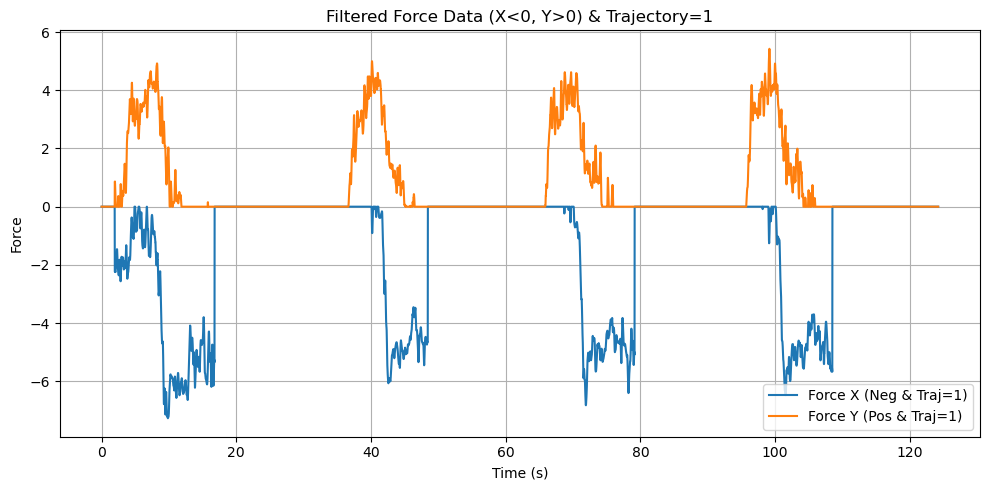

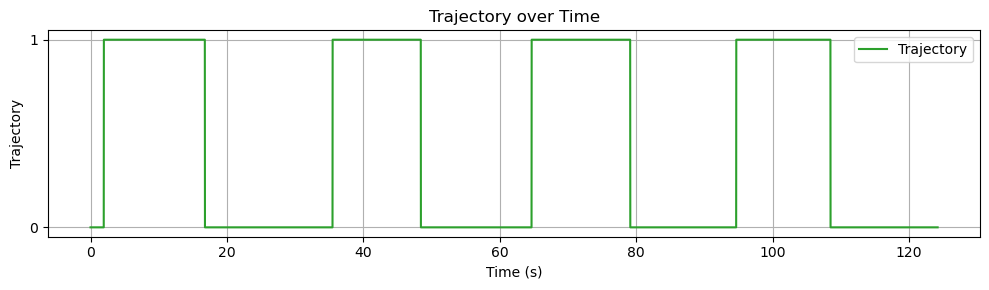

In [12]:
# 2) Force X<0, Force Y>0 필터링 & 시각화 (C0/C1 색상)
fx_neg = np.where(fx < 0, fx, 0)
fy_pos = np.where(fy > 0, fy, 0)

plt.figure(figsize=(10,5))
plt.plot(time, fx_neg, color='C0', label='Force X (Neg)')  # 파란색
plt.plot(time, fy_pos, color='C1', label='Force Y (Pos)')  # 주황색
plt.title('Filtered Force Data (X<0 → Keep, Y>0 → Keep)')
plt.xlabel('Time (s)')
plt.ylabel('Force')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 3) #2에서 만든 fx_neg, fy_pos에 Trajectory=1 마스크 적용 & 시각화
traj = tdms[group]['Trajectory'][:]    # Trajectory 로드
mask = (traj == 1)                     # Traj=1 위치

# Traj=1 아닌 곳은 0으로 (혹은 np.nan으로 할 수도 있음)
fx_neg_traj = np.where(mask, fx_neg, 0)
fy_pos_traj = np.where(mask, fy_pos, 0)

plt.figure(figsize=(10,5))
plt.plot(time, fx_neg_traj, color='C0', label='Force X (Neg & Traj=1)')
plt.plot(time, fy_pos_traj, color='C1', label='Force Y (Pos & Traj=1)')
plt.title('Filtered Force Data (X<0, Y>0) & Trajectory=1')
plt.xlabel('Time (s)')
plt.ylabel('Force')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,3))
plt.plot(time, traj, color='C2', label='Trajectory')
plt.title('Trajectory over Time')
plt.xlabel('Time (s)')
plt.ylabel('Trajectory')
plt.yticks([0, 1])
plt.grid(True)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

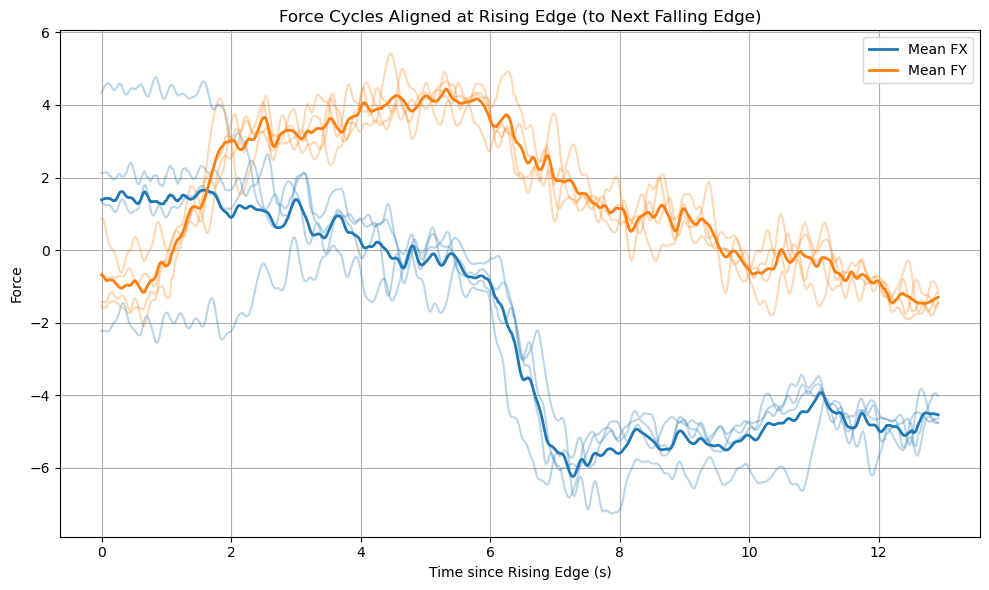

In [13]:
# 4) Rising edge → 다음 Falling edge 기준으로 Force cycle overlay
traj = tdms[group]['Trajectory'][:]  
# ① rising edge 인덱스 (0→1)
rising_idx = np.where((traj[:-1] == 0) & (traj[1:] == 1))[0] + 1
# ② falling edge 인덱스 (1→0)
falling_all = np.where((traj[:-1] == 1) & (traj[1:] == 0))[0] + 1

# ③ 각 rising edge마다 그 다음 falling edge 찾기
falling_idx = []
for r in rising_idx:
    # 모든 falling 중 r보다 큰 것만
    candidates = falling_all[falling_all > r]
    if len(candidates) > 0:
        falling_idx.append(candidates[0])
# (rising/falling 쌍 개수가 같은지 확인)
assert len(falling_idx) == len(rising_idx), "모든 rising edge에 대응하는 falling edge가 필요합니다."

# ④ 각 사이클 길이 = falling - rising → 최소 길이 기준
lengths = np.array(falling_idx) - np.array(rising_idx)
min_len = lengths.min()

# ⑤ 세그먼트 추출 (모두 min_len 길이)
segments_fx = [fx[r : r + min_len] for r in rising_idx]
segments_fy = [fy[r : r + min_len] for r in rising_idx]

# ⑥ 상대 시간 축 (s)
t_rel = np.arange(min_len) / 50

# ⑦ 오버레이 플롯
plt.figure(figsize=(10,6))
for seg in segments_fx:
    plt.plot(t_rel, seg, color='C0', alpha=0.3, label='_nolegend_')
for seg in segments_fy:
    plt.plot(t_rel, seg, color='C1', alpha=0.3, label='_nolegend_')

# 평균 사이클
mean_fx = np.mean(segments_fx, axis=0)
mean_fy = np.mean(segments_fy, axis=0)
plt.plot(t_rel, mean_fx, color='C0', linewidth=2, label='Mean FX')
plt.plot(t_rel, mean_fy, color='C1', linewidth=2, label='Mean FY')

plt.title('Force Cycles Aligned at Rising Edge (to Next Falling Edge)')
plt.xlabel('Time since Rising Edge (s)')
plt.ylabel('Force')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


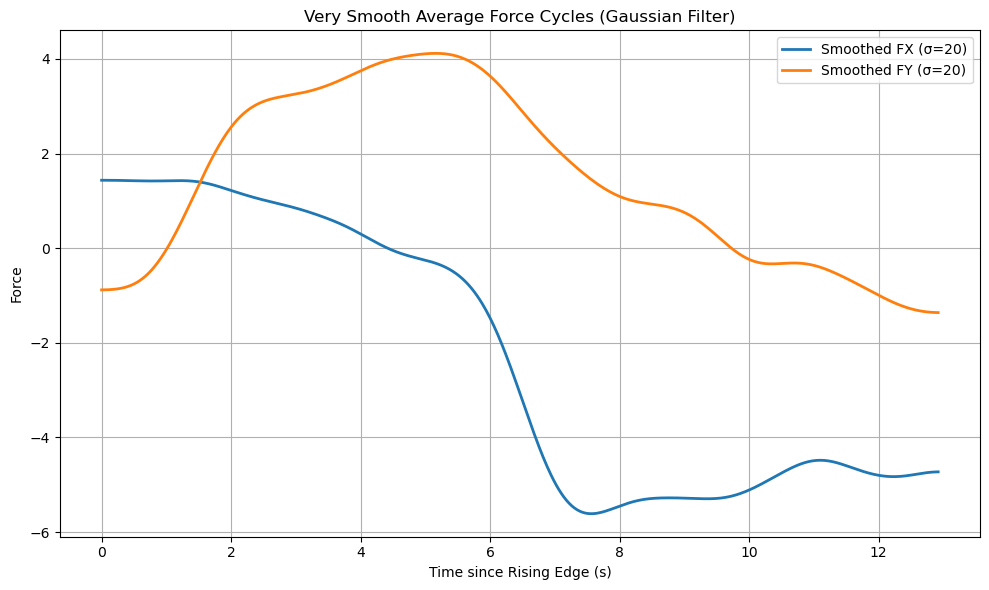

In [14]:
from scipy.ndimage import gaussian_filter1d

# mean_fx, mean_fy: 앞서 계산된 평균 사이클 (길이 N)
# t_rel: 정규화된 시간 축

# sigma 를 키워서 부드러움 극대화 (예: 10, 20, 30…)
sigma = 20  

smooth_fx = gaussian_filter1d(mean_fx, sigma=sigma)
smooth_fy = gaussian_filter1d(mean_fy, sigma=sigma)

plt.figure(figsize=(10,6))
plt.plot(t_rel, smooth_fx, color='C0', linewidth=2, label=f'Smoothed FX (σ={sigma})')
plt.plot(t_rel, smooth_fy, color='C1', linewidth=2, label=f'Smoothed FY (σ={sigma})')

plt.title('Very Smooth Average Force Cycles (Gaussian Filter)')
plt.xlabel('Time since Rising Edge (s)')
plt.ylabel('Force')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


✅ Available groups and channels:
 - Group: Datas
    • Time (ms)
    • Reference Position X
    • Reference Position Y
    • Measured Position X
    • Measured Position Y
    • Reference Tension L
    • Reference Tension R
    • Reference Tension T
    • Measured Tension L
    • Measured Tension R
    • Measured Tension T
    • RBF1
    • RBF2
    • RBF3
    • Trajectory
    • Performance
    • Force X
    • Force y
    • Damp1
    • Damp2
    • Damp3


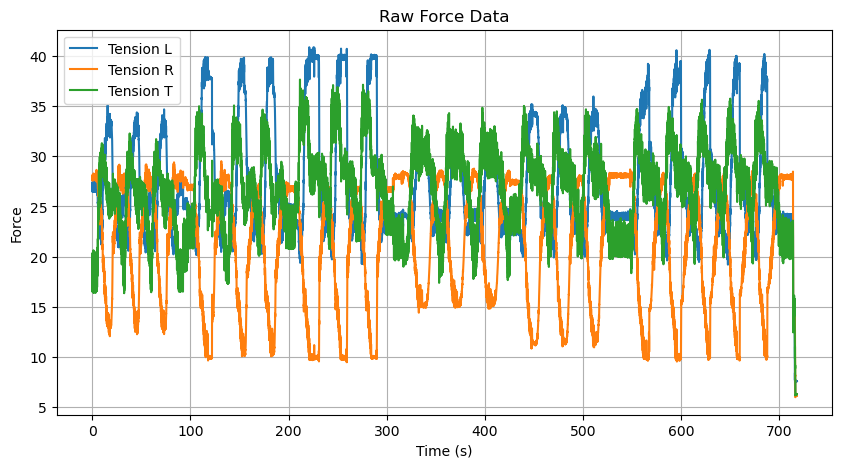